# Offline Highway Demo

In [1]:
# Importing necessary libraries and modules
import gymnasium as gym
from IPython.display import display, clear_output
from matplotlib import pyplot as plt
import time
from functools import partial
from typing import Optional
from datetime import datetime
import os
import numpy as np
import sys

root_dir = os.path.abspath('..')
sys.path.append(root_dir)

# Importing custom modules
from utils import Logger,  load_initial_instructions# utils.py in the root directory
from envs.tabular_mdp.env import TabularMDP, State
from agents.StriDe import StriDeAgent
import highway_env
from highway_env import utils
from highway_env.vehicle.kinematics import Vehicle
from copy import deepcopy




In [2]:
def compute_ttc_grid(
    env: "AbstractEnv",
    time_quantization: float,
    horizon: float,
    vehicle: Optional[Vehicle] = None,
) -> np.ndarray:
    """
    Compute the grid of predicted time-to-collision to each vehicle within the lane

    For each ego-speed and lane.
    :param env: environment
    :param time_quantization: time step of a grid cell
    :param horizon: time horizon of the grid
    :param vehicle: the observer vehicle
    :return: the time-co-collision grid, with axes SPEED x LANES x TIME
    """
    vehicle = vehicle or env.vehicle
    road_lanes = env.road.network.all_side_lanes(env.vehicle.lane_index)
    grid = np.zeros(
        (vehicle.target_speeds.size, len(road_lanes), int(horizon / time_quantization))
    )
    for speed_index in range(grid.shape[0]):
        ego_speed = vehicle.index_to_speed(speed_index)
        for other in env.road.vehicles:
            if (other is vehicle) or (ego_speed == other.speed):
                continue
            margin = other.LENGTH / 2 + vehicle.LENGTH / 2
            collision_points = [(0, 1), (-margin, 0.5), (margin, 0.5)]
            for m, cost in collision_points:
                distance = vehicle.lane_distance_to(other) + m
                other_projected_speed = other.speed * np.dot(
                    other.direction, vehicle.direction
                )
                time_to_collision = distance / utils.not_zero(
                    ego_speed - other_projected_speed
                )
                if time_to_collision < 0:
                    continue
                if env.road.network.is_connected_road(
                    vehicle.lane_index, other.lane_index, route=vehicle.route, depth=3
                ):
                    # Same road, or connected road with same number of lanes
                    if len(env.road.network.all_side_lanes(other.lane_index)) == len(
                        env.road.network.all_side_lanes(vehicle.lane_index)
                    ):
                        lane = [other.lane_index[2]]
                    # Different road of different number of lanes: uncertainty on future lane, use all
                    else:
                        lane = range(grid.shape[1])
                    # Quantize time-to-collision to both upper and lower values
                    for time in [
                        int(time_to_collision / time_quantization),
                        int(np.ceil(time_to_collision / time_quantization)),
                    ]:
                        if 0 <= time < grid.shape[2]:
                            # TODO: check lane overflow (e.g. vehicle with higher lane id than current road capacity)
                            grid[speed_index, lane, time] = np.maximum(
                                grid[speed_index, lane, time], cost
                            )
    return grid



def transition_model(h: int, i: int, j: int, a: int, grid: np.ndarray) -> np.ndarray:
    """
    Deterministic transition from a position in the grid to the next.

    :param h: speed index
    :param i: lane index
    :param j: time index
    :param a: action index
    :param grid: ttc grid specifying the limits of speeds, lanes, time and actions
    """
    # Idle action (1) as default transition
    next_state = clip_position(h, i, j + 1, grid)
    left = a == 0
    right = a == 2
    faster = (a == 3) & (j == 0)
    slower = (a == 4) & (j == 0)
    next_state[left] = clip_position(h[left], i[left] - 1, j[left] + 1, grid)
    next_state[right] = clip_position(h[right], i[right] + 1, j[right] + 1, grid)
    next_state[faster] = clip_position(h[faster] + 1, i[faster], j[faster] + 1, grid)
    next_state[slower] = clip_position(h[slower] - 1, i[slower], j[slower] + 1, grid)
    return next_state



def clip_position(h: int, i: int, j: int, grid: np.ndarray) -> np.ndarray:
    """
    Clip a position in the TTC grid, so that it stays within bounds.

    :param h: speed index
    :param i: lane index
    :param j: time index
    :param grid: the ttc grid
    :return: The raveled index of the clipped position
    """
    h = np.clip(h, 0, grid.shape[0] - 1)
    i = np.clip(i, 0, grid.shape[1] - 1)
    j = np.clip(j, 0, grid.shape[2] - 1)
    indexes = np.ravel_multi_index((h, i, j), grid.shape)
    return indexes



def to_finite_mdp(env: "AbstractEnv",horizon:float = 5):
    """
    Convert the given environment to a finite Markov Decision Process (MDP).

    Parameters:
    env (AbstractEnv): The environment to convert, which should contain configurations
                       such as policy frequency, vehicle state, action space, and rewards.

    Returns:
    tuple: A tuple containing the number of states, number of actions, the initial state,
           the state transition probability matrix, and the reward matrix.
    """

    # Determine the time quantization and horizon based on the environment's policy frequency
    time_quantization = 1 / env.unwrapped.config["policy_frequency"]

    # Compute the time-to-collision (TTC) grid for the environment
    grid = compute_ttc_grid(env, time_quantization, horizon)

    # Initialize the grid state and convert it to a single state index
    grid_state = (env.vehicle.speed_index, env.vehicle.lane_index[2], 0)
    state = np.ravel_multi_index(grid_state, grid.shape)

    # Define a partial transition model function that includes the grid
    transition_model_with_grid = partial(transition_model, grid=grid)

    # Compute the transition index matrix for all state-action pairs
    transition_index_matrix = np.fromfunction(
        transition_model_with_grid, grid.shape + (env.action_space.n,), dtype=int
    )
    transition_index_matrix = np.reshape(transition_index_matrix, (np.size(grid), env.action_space.n))

    # Compute the reward function for each state
    v, l, t = grid.shape
    lanes = np.arange(l) / max(l - 1, 1)
    speeds = np.arange(v) / max(v - 1, 1)

    state_reward = (
        + env.unwrapped.config["collision_reward"] * grid
        + env.unwrapped.config["right_lane_reward"]
        * np.tile(lanes[np.newaxis, :, np.newaxis], (v, 1, t))
        + env.unwrapped.config["high_speed_reward"]
        * np.tile(speeds[:, np.newaxis, np.newaxis], (1, l, t))
    )

    state_reward = np.ravel(state_reward)


    # Combine state and action rewards into a single reward function
    reward = np.fromfunction(
        np.vectorize(lambda s, a: state_reward[s]),
        (np.size(state_reward), env.action_space.n),
        dtype=int,
    )

    # Identify terminal states based on collision or end of horizon
    collision = grid == 1
    end_of_horizon = np.fromfunction(
        lambda h, i, j: j == grid.shape[2] - 1, grid.shape, dtype=int
    )
    terminal = np.ravel(collision | end_of_horizon)

    # Initialize the state transition probability matrix
    nState = np.product(grid.shape)  # Total number of states
    nAction = env.action_space.n  # Number of actions from the environment
    P_true = np.zeros((nState, nAction, nState), dtype=np.float32)

    # Fill in the state transition probability matrix
    for s in range(nState):
        if terminal[s]:  # If the state is terminal
            for a in range(nAction):
                P_true[s, a, s] = 1.0  # Self-transition for terminal states
        else:  # If the state is not terminal
            for a in range(nAction):
                next_s = transition_index_matrix[s, a]
                P_true[s, a, next_s] = 1.0

    # Define the mean and variance of the reward
    R_true_mean = reward
    R_true_var = np.zeros((nState, nAction))
    R_true_mean = np.expand_dims(R_true_mean, axis=-1)
    R_true_var = np.expand_dims(R_true_var, axis=-1)
    R_true = np.concatenate((R_true_mean, R_true_var), axis=-1)

    return (nState, nAction, state, P_true, R_true)


def create_env():
    '''
    create an highway environment
    '''

    env = gym.make('highway-v0', render_mode='rgb_array')
    env.unwrapped.config["collision_reward"] = -100
    env.unwrapped.config["high_speed_reward"] = 2
    env.unwrapped.config["right_lane_reward"] = 5
    # Create a stationary MDP
    for vehicle in env.unwrapped.road.vehicles:
      vehicle.enabled_lane_change = False

    return env
    

def get_result(env_mdp, agents, state, action, logger):
    q_optimal, _ = env_mdp.compute_qVals()
    q = q_optimal[state.time_step, state.mathematical_descript]
    logger.write("q_optimal for current step and state {}".format(q))
    optimal_actions = np.where(q==np.max(q))
    if np.isin(action, optimal_actions):
        success = True
    else:
        success = False
    return success



def run_mdp(env_mdp, agents, logger):
    actions = []


    # Reset agents and get instance descriptions
    for role in agents:
        agents[role].reset()
        instance_description = env_mdp.get_description(agent_role=role, episode_ind=1, mdp_known=True)
        agents[role].get_instance_info(instance_description)
        logger.write("To {}:".format(role))
        logger.write(instance_description)


    # repeatively play the same instance of the env (e.g., MDP with unknown env model)
    agents["agent"].reason("Now compute the optimal policy, that is, the optimal action at each step and each state.")
    metric_ls = []
    state = env_mdp.state # initial state


    while not env_mdp.is_done: # in case game never ends due to failure in checking terminal condition
        logger.write(state.textual_descript, color = "red")
        cur_agent = agents[state.cur_agent]
        action = cur_agent.move(state)
        actions.append(action)
        old_state = deepcopy(state)
        metric = get_result(env_mdp, agents, state, action, logger)
        metric_ls.append(metric)
        logger.write("{}: {}".format(state.cur_agent, action), color = "red")
        logger.write("metric: {}".format(metric), color = "red")
        state, reward = env_mdp.step(action)

    logger.write("This episode has ended!", color="red")

    logger.write("Performance metric: {}".format(metric_ls))
    return actions


def create_agents(env, logger, agent_type, agent_engine, mdp_known=True):
    if env.name == "tabular_mdp" and mdp_known:
        demo = load_initial_instructions("../envs/tabular_mdp/prompts/tabular_mdp_vi_exmps.txt")
        from envs.tabular_mdp.tools import tool_names_mdp_known
        init_memory = {"P":env.P, 
                       "R":env.R, 
                       "nState":env.nState, 
                       "nAction":env.nAction, 
                       "epLen":env.epLen,
                       "V": np.zeros((env.epLen,env.nState)),
                       "Q": np.zeros((env.epLen,env.nState,env.nAction)),
                       }

        agent = StriDeAgent(problem_description=env.description_of_problem_class, demo=demo, tool_names=tool_names_mdp_known, init_memory=init_memory, logger=logger, engine=agent_engine)
        return {"agent":agent}



def play_through(env:"AbstractEnv", horizon:float, logger:Logger):
    images = []
        
    # Convert the environment to a finite MDP
    nState, nAction, state, P_true, R_true = to_finite_mdp(env, horizon = horizon)
    
    # Create Tabular MDP environment with the parameters
    env_mdp = TabularMDP(env_param={
        "nState": nState,
        "nAction": nAction,
        "epLen": horizon,
        "R": R_true,
        "P": P_true,
    })
    
    env_mdp.state = State(time_step=0, cur_agent="agent", actions=[a for a in range(env_mdp.nAction)], action_schema=[("action", "integer", "the action chosen by the agent, which should be in {}.".format([a for a in range(env_mdp.nAction)]))], textual_descript="This is time step {}, the current state is {}, and the available actions are {}.\nQuestion: Now which action the agent should take?".format(0, state, [a for a in range(env_mdp.nAction)]), mathematical_descript=state)

    # Create agents for the environment
    agents = create_agents(env_mdp, logger, "stride", "gpt-4o")
    
    # Check if all required agents are specified
    if not env_mdp.check_agents(agents):
        raise ValueError(f"Illegal agents for env {env_mdp}")
    
    logger.write(f"Start to play {env_mdp.name} with parameter {env_mdp.env_param}", color="red")
    
    # Get the actions generated by the gpt
    actions = run_mdp(env_mdp=env_mdp, agents=agents, logger=logger)
    
    # Iterate through the steps and execute actions
    for action in actions:  
        env.step(action)
        img = env.render()
        images.append(img)

    return images

In [3]:
# Parameters
horizon = 10


# Create environment and reset it
env = create_env()
env.reset()

# Setup output logger to test MDP performance
output_path = "./outputs/tabular_mdp/"
os.makedirs(output_path, exist_ok=True)
now = datetime.now()
time_string = now.strftime('%Y%m%d%H%M%S')
logger = Logger(os.path.join(output_path, f"tabular_mdp-{time_string}.html"), 1)

images = play_through(env = env,horizon = horizon, logger = logger)

All outputs written to ./outputs/tabular_mdp/tabular_mdp-20240603010604.html

d:\anaconda\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.vehicle to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.vehicle` for environment variables or `env.get_wrapper_attr('vehicle')` that will search the reminding wrappers.
  logger.warn(
d:\anaconda\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.road to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.road` for environment variables or `env.get_wrapper_attr('road')` that will search the reminding wrappers.
  logger.warn(


Start to play tabular_mdp with parameter {'nState': 120, 'nAction': 5, 'epLen': 10, 'R': array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       ...,

       [[7., 0.],
        [7., 0.],
        [7., 0.],
        [7., 0.],
        [7., 0.]],

       [[7., 0.],
        [7., 0.],
        [7., 0.],
        [7., 0.],
        [7., 0.]],

       [[7., 0.],
        [7., 0.],
        [7., 0.],
        [7., 0.],
        [7., 0.]]]), 'P': array([[[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]],

       [[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]], dtype=float32)}

To agent:

Now you are going to play in a finite-horizon tabular Markov decision process, with length of horizon 10 (with time
indices starting from h=0 to 9), number of states |S|=120, number of actions |A|=5. The transition matrix P is:
stored in working memory. Full matrix is too large to be printed in context history.
and reward matrix R is
stored in working memory. Full matrix is too large to be printed in context history.

Question: Now compute the optimal policy, that is, the optimal action at each step and each state.

Thought: To compute the optimal policy, we will use value iteration, iterating from the last time step 9 back to 
the first time step 0. At the last time step 9, the Q values simply equal the immediate reward of each state-action
pair. We will start by updating the Q values for time step 9 with the immediate rewards and then compute the V 
values by taking the maximum of the Q values over actions.

Operation: call function UpdateQbyR with inputs time_step=9

Result: Q values for time step 9 are updated with the immediate rewards and stored in the working memory.

Thought: Now we need to compute the V values for time step 9 by taking the maximum of the Q values over actions.

Operation: call function UpdateV with inputs time_step=9

Result: V values for time step 9 are updated based on the computed Q values and stored in the working memory.

Thought: Now we need to compute the Q values for time step 8. Using the idea of dynamic programming, we compute the
Q values in two steps. First, add the immediate rewards by calling function UpdateQbyR. Second, add the one-step 
lookahead by calling function UpdateQbyPV. Then the V values can be computed by calling UpdateV, which takes the 
maximum of the Q values over actions.

Operation: call function UpdateQbyR with inputs time_step=8

Result: Q values for time step 8 are updated with the immediate rewards and stored in the working memory.

Operation: call function UpdateQbyPV with inputs time_step=8

Result: Q values for time step 8 are updated with the one-step look ahead and stored in the working memory.

Operation: call function UpdateV with inputs time_step=8

Result: V values for time step 8 are updated based on the computed Q values and stored in the working memory.

Thought: Now we need to compute the Q values for time step 7. Using the idea of dynamic programming, we compute the
Q values in two steps. First, add the immediate rewards by calling function UpdateQbyR. Second, add the one-step 
lookahead by calling function UpdateQbyPV. Then the V values can be computed by calling UpdateV, which takes the 
maximum of the Q values over actions.

Operation: call function UpdateQbyR with inputs time_step=7

Result: Q values for time step 7 are updated with the immediate rewards and stored in the working memory.

Operation: call function UpdateQbyPV with inputs time_step=7

Result: Q values for time step 7 are updated with the one-step look ahead and stored in the working memory.

Operation: call function UpdateV with inputs time_step=7

Result: V values for time step 7 are updated based on the computed Q values and stored in the working memory.

Thought: Now we need to compute the Q values for time step 6. Using the idea of dynamic programming, we compute the
Q values in two steps. First, add the immediate rewards by calling function UpdateQbyR. Second, add the one-step 
lookahead by calling function UpdateQbyPV. Then the V values can be computed by calling UpdateV, which takes the 
maximum of the Q values over actions.

Operation: call function UpdateQbyR with inputs time_step=6

Result: Q values for time step 6 are updated with the immediate rewards and stored in the working memory.

Operation: call function UpdateQbyPV with inputs time_step=6

Result: Q values for time step 6 are updated with the one-step look ahead and stored in the working memory.

Operation: call function UpdateV with inputs time_step=6

Result: V values for time step 6 are updated based on the computed Q values and stored in the working memory.

Thought: Now we need to compute the Q values for time step 5. Using the idea of dynamic programming, we compute the
Q values in two steps. First, add the immediate rewards by calling function UpdateQbyR. Second, add the one-step 
lookahead by calling function UpdateQbyPV. Then the V values can be computed by calling UpdateV, which takes the 
maximum of the Q values over actions.

Operation: call function UpdateQbyR with inputs time_step=5

Result: Q values for time step 5 are updated with the immediate rewards and stored in the working memory.

Operation: call function UpdateQbyPV with inputs time_step=5

Result: Q values for time step 5 are updated with the one-step look ahead and stored in the working memory.

Operation: call function UpdateV with inputs time_step=5

Result: V values for time step 5 are updated based on the computed Q values and stored in the working memory.

Thought: Now we need to compute the Q values for time step 4. Using the idea of dynamic programming, we compute the
Q values in two steps. First, add the immediate rewards by calling function UpdateQbyR. Second, add the one-step 
lookahead by calling function UpdateQbyPV. Then the V values can be computed by calling UpdateV, which takes the 
maximum of the Q values over actions.

Operation: call function UpdateQbyR with inputs time_step=4

Result: Q values for time step 4 are updated with the immediate rewards and stored in the working memory.

Operation: call function UpdateQbyPV with inputs time_step=4

Result: Q values for time step 4 are updated with the one-step look ahead and stored in the working memory.

Operation: call function UpdateV with inputs time_step=4

Result: V values for time step 4 are updated based on the computed Q values and stored in the working memory.

Thought: Now we need to compute the Q values for time step 3. Using the idea of dynamic programming, we compute the
Q values in two steps. First, add the immediate rewards by calling function UpdateQbyR. Second, add the one-step 
lookahead by calling function UpdateQbyPV. Then the V values can be computed by calling UpdateV, which takes the 
maximum of the Q values over actions.

Operation: call function UpdateQbyR with inputs time_step=3

Result: Q values for time step 3 are updated with the immediate rewards and stored in the working memory.

Operation: call function UpdateQbyPV with inputs time_step=3

Result: Q values for time step 3 are updated with the one-step look ahead and stored in the working memory.

Operation: call function UpdateV with inputs time_step=3

Result: V values for time step 3 are updated based on the computed Q values and stored in the working memory.

Thought: Now we need to compute the Q values for time step 2. Using the idea of dynamic programming, we compute the
Q values in two steps. First, add the immediate rewards by calling function UpdateQbyR. Second, add the one-step 
lookahead by calling function UpdateQbyPV. Then the V values can be computed by calling UpdateV, which takes the 
maximum of the Q values over actions.

Operation: call function UpdateQbyR with inputs time_step=2

Result: Q values for time step 2 are updated with the immediate rewards and stored in the working memory.

Operation: call function UpdateQbyPV with inputs time_step=2

Result: Q values for time step 2 are updated with the one-step look ahead and stored in the working memory.

Operation: call function UpdateV with inputs time_step=2

Result: V values for time step 2 are updated based on the computed Q values and stored in the working memory.

Thought: Now we need to compute the Q values for time step 1. Using the idea of dynamic programming, we compute the
Q values in two steps. First, add the immediate rewards by calling function UpdateQbyR. Second, add the one-step 
lookahead by calling function UpdateQbyPV. Then the V values can be computed by calling UpdateV, which takes the 
maximum of the Q values over actions.

Operation: call function UpdateQbyR with inputs time_step=1

Result: Q values for time step 1 are updated with the immediate rewards and stored in the working memory.

Operation: call function UpdateQbyPV with inputs time_step=1

Result: Q values for time step 1 are updated with the one-step look ahead and stored in the working memory.

Operation: call function UpdateV with inputs time_step=1

Result: V values for time step 1 are updated based on the computed Q values and stored in the working memory.

Thought: Now we need to compute the Q values for time step 0. Using the idea of dynamic programming, we compute the
Q values in two steps. First, add the immediate rewards by calling function UpdateQbyR. Second, add the one-step 
lookahead by calling function UpdateQbyPV. Then the V values can be computed by calling UpdateV, which takes the 
maximum of the Q values over actions.

Operation: call function UpdateQbyR with inputs time_step=0

Result: Q values for time step 0 are updated with the immediate rewards and stored in the working memory.

Operation: call function UpdateQbyPV with inputs time_step=0

Result: Q values for time step 0 are updated with the one-step look ahead and stored in the working memory.

Operation: call function UpdateV with inputs time_step=0

Result: V values for time step 0 are updated based on the computed Q values and stored in the working memory.

Thought: The Q values from the last time step 9 to time step 0 have now been calculated. We should exit the 
reasoning process.

This is time step 0, the current state is 70, and the available actions are [0, 1, 2, 3, 4].
Question: Now which action the agent should take?

Question: This is time step 0, the current state is 70, and the available actions are [0, 1, 2, 3, 4].
Question: Now which action the agent should take?

Thought: I should retrieve the Q values for the current state, which is 70, and time step, which is 0.

Operation: call function GetQ with inputs time_step=0 state=70

Result: [53.3333 55.     55.     64.     51.    ]

Thought: I should call function GetArgMax to get the action indices corresponding to the maximal value in the list 
[53.3333, 55, 55, 64, 51].

Operation: call function GetArgMax with inputs number_list=[53.3333, 55.0, 55.0, 64.0, 51.0]

Result: [3]

Thought: Now I can exit the reasoning process, and choose action 3, as it maximizes the Q value (break the tie 
randomly if there are multiple maximums).

q_optimal for current step and state [53.33333333 55.         55.         64.         51.        ]

agent: 3

metric: True

This is time step 1, the current state is 111, and the available actions are [0, 1, 2, 3, 4].
Question: Now which action the agent should take?

Question: This is time step 1, the current state is 111, and the available actions are [0, 1, 2, 3, 4].
Question: Now which action the agent should take?

Thought: I should retrieve the Q values for the current state, which is 111, and time step, which is 1.

Operation: call function GetQ with inputs time_step=1 state=111

Result: [58.      9.6667  9.6667  9.6667  9.6667]

Thought: I should call function GetArgMax to get the action indices corresponding to the maximal value in the list 
[58, 9.6667, 9.6667, 9.6667, 9.6667].

Operation: call function GetArgMax with inputs number_list=[58.0, 9.6667, 9.6667, 9.6667, 9.6667]

Result: [0]

Thought: Now I can exit the reasoning process, and choose action 0, as it maximizes the Q value (break the tie 
randomly if there are multiple maximums).

q_optimal for current step and state [58.          9.66666667  9.66666667  9.66666667  9.66666667]

agent: 0

metric: True

This is time step 2, the current state is 102, and the available actions are [0, 1, 2, 3, 4].
Question: Now which action the agent should take?

Question: This is time step 2, the current state is 102, and the available actions are [0, 1, 2, 3, 4].
Question: Now which action the agent should take?

Thought: I should retrieve the Q values for the current state, which is 102, and time step, which is 2.

Operation: call function GetQ with inputs time_step=2 state=102

Result: [  49.3333   51.     -645.6667   51.       51.    ]

Thought: I should call function GetArgMax to get the action indices corresponding to the maximal value in the list 
[49.3333, 51, -645.6667, 51, 51].

Operation: call function GetArgMax with inputs number_list=[49.3333, 51.0, -645.6667, 51.0, 51.0]

Result: [1 3 4]

Thought: There are multiple actions (1, 3, and 4) that maximize the Q value. I will randomly choose one of these 
actions.

q_optimal for current step and state [  49.33333333   51.         -645.66666667   51.           51.        ]

agent: 1

metric: True

This is time step 3, the current state is 103, and the available actions are [0, 1, 2, 3, 4].
Question: Now which action the agent should take?

Question: This is time step 3, the current state is 103, and the available actions are [0, 1, 2, 3, 4].
Question: Now which action the agent should take?

Thought: I should retrieve the Q values for the current state, which is 103, and time step, which is 3.

Operation: call function GetQ with inputs time_step=3 state=103

Result: [  42.3333   45.6667 -552.6667   45.6667   45.6667]

Thought: I should call function GetArgMax to get the action indices corresponding to the maximal value in the list 
[42.3333, 45.6667, -552.6667, 45.6667, 45.6667].

Operation: call function GetArgMax with inputs number_list=[42.3333, 45.6667, -552.6667, 45.6667, 45.6667]

Result: [1 3 4]

Thought: There are multiple actions (1, 3, and 4) that maximize the Q value. I will randomly choose one of these 
actions.

q_optimal for current step and state [  42.33333333   45.66666667 -552.66666667   45.66666667   45.66666667]

agent: 1

metric: True

This is time step 4, the current state is 104, and the available actions are [0, 1, 2, 3, 4].
Question: Now which action the agent should take?

Question: This is time step 4, the current state is 104, and the available actions are [0, 1, 2, 3, 4].
Question: Now which action the agent should take?

Thought: I should retrieve the Q values for the current state, which is 104, and time step, which is 4.

Operation: call function GetQ with inputs time_step=4 state=104

Result: [35.3333 38.6667 40.3333 38.6667 38.6667]

Thought: I should call function GetArgMax to get the action indices corresponding to the maximal value in the list 
[35.3333, 38.6667, 40.3333, 38.6667, 38.6667].

Operation: call function GetArgMax with inputs number_list=[35.3333, 38.6667, 40.3333, 38.6667, 38.6667]

Result: [2]

Thought: Now I can exit the reasoning process, and choose action 2, as it maximizes the Q value (break the tie 
randomly if there are multiple maximums).

q_optimal for current step and state [35.33333333 38.66666667 40.33333333 38.66666667 38.66666667]

agent: 2

metric: True

This is time step 5, the current state is 115, and the available actions are [0, 1, 2, 3, 4].
Question: Now which action the agent should take?

Question: This is time step 5, the current state is 115, and the available actions are [0, 1, 2, 3, 4].
Question: Now which action the agent should take?

Thought: I should retrieve the Q values for the current state, which is 115, and time step, which is 5.

Operation: call function GetQ with inputs time_step=5 state=115

Result: [33.3333 35.     35.     35.     35.    ]

Thought: I should call function GetArgMax to get the action indices corresponding to the maximal value in the list 
[33.3333, 35, 35, 35, 35].

Operation: call function GetArgMax with inputs number_list=[33.3333, 35.0, 35.0, 35.0, 35.0]

Result: [1 2 3 4]

Thought: There are multiple actions (1, 2, 3, and 4) that maximize the Q value. I will randomly choose one of these
actions.

q_optimal for current step and state [33.33333333 35.         35.         35.         35.        ]

agent: 1

metric: True

This is time step 6, the current state is 116, and the available actions are [0, 1, 2, 3, 4].
Question: Now which action the agent should take?

Question: This is time step 6, the current state is 116, and the available actions are [0, 1, 2, 3, 4].
Question: Now which action the agent should take?

Thought: I should retrieve the Q values for the current state, which is 116, and time step, which is 6.

Operation: call function GetQ with inputs time_step=6 state=116

Result: [26.3333 28.     28.     28.     28.    ]

Thought: I should call function GetArgMax to get the action indices corresponding to the maximal value in the list 
[26.3333, 28, 28, 28, 28].

Operation: call function GetArgMax with inputs number_list=[26.3333, 28.0, 28.0, 28.0, 28.0]

Result: [1 2 3 4]

Thought: There are multiple actions (1, 2, 3, and 4) that maximize the Q value. I will randomly choose one of these
actions.

q_optimal for current step and state [26.33333333 28.         28.         28.         28.        ]

agent: 2

metric: True

This is time step 7, the current state is 117, and the available actions are [0, 1, 2, 3, 4].
Question: Now which action the agent should take?

Question: This is time step 7, the current state is 117, and the available actions are [0, 1, 2, 3, 4].
Question: Now which action the agent should take?

Thought: I should retrieve the Q values for the current state, which is 117, and time step, which is 7.

Operation: call function GetQ with inputs time_step=7 state=117

Result: [19.3333 21.     21.     21.     21.    ]

Thought: I should call function GetArgMax to get the action indices corresponding to the maximal value in the list 
[19.3333, 21, 21, 21, 21].

Operation: call function GetArgMax with inputs number_list=[19.3333, 21.0, 21.0, 21.0, 21.0]

Result: [1 2 3 4]

Thought: There are multiple actions (1, 2, 3, and 4) that maximize the Q value. I will randomly choose one of these
actions.

q_optimal for current step and state [19.33333333 21.         21.         21.         21.        ]

agent: 2

metric: True

This is time step 8, the current state is 118, and the available actions are [0, 1, 2, 3, 4].
Question: Now which action the agent should take?

Question: This is time step 8, the current state is 118, and the available actions are [0, 1, 2, 3, 4].
Question: Now which action the agent should take?

Thought: I should retrieve the Q values for the current state, which is 118, and time step, which is 8.

Operation: call function GetQ with inputs time_step=8 state=118

Result: [12.3333 14.     14.     14.     14.    ]

Thought: I should call function GetArgMax to get the action indices corresponding to the maximal value in the list 
[12.3333, 14, 14, 14, 14].

Operation: call function GetArgMax with inputs number_list=[12.3333, 14.0, 14.0, 14.0, 14.0]

Result: [1 2 3 4]

Thought: There are multiple actions (1, 2, 3, and 4) that maximize the Q value. I will randomly choose one of these
actions.

q_optimal for current step and state [12.33333333 14.         14.         14.         14.        ]

agent: 2

metric: True

This is time step 9, the current state is 119, and the available actions are [0, 1, 2, 3, 4].
Question: Now which action the agent should take?

Question: This is time step 9, the current state is 119, and the available actions are [0, 1, 2, 3, 4].
Question: Now which action the agent should take?

Thought: I should retrieve the Q values for the current state, which is 119, and time step, which is 9.

Operation: call function GetQ with inputs time_step=9 state=119

Result: [7. 7. 7. 7. 7.]

Thought: I should call function GetArgMax to get the action indices corresponding to the maximal value in the list 
[7, 7, 7, 7, 7].

Operation: call function GetArgMax with inputs number_list=[7.0, 7.0, 7.0, 7.0, 7.0]

Result: [0 1 2 3 4]

Thought: There are multiple actions (0, 1, 2, 3, and 4) that maximize the Q value. I will randomly choose one of 
these actions.

q_optimal for current step and state [7. 7. 7. 7. 7.]

agent: 2

metric: True

This episode has ended!

Performance metric: [True, True, True, True, True, True, True, True, True, True]

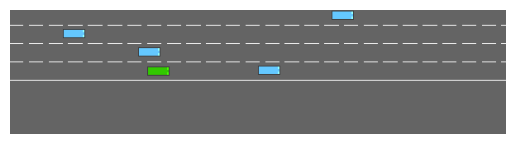

In [5]:
# Show the video
for img in images:
  clear_output(wait=True)
  plt.imshow(img)
  plt.axis('off')  
  display(plt.gcf())
  plt.close()  
  time.sleep(0.1)  